<div style="display: flex;">
    <h1 style="margin: auto; font-weight: bold; color: black; padding: 30px 30px 0px 30px;" align="center"> Projet 6 : 
Classifiez automatiquement des biens de consommation
 </h1>
</div>

<div style="display: flex; margin: auto; padding: 5px 30px 0px 30px;" > <h2 style="width: 100%; text-align: center; color: black; float: left;" align="center"> Pretraitement feature extraction et faisabilité </h2> 
</div>

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">0. Import et exploration du jeu de données </h3>
</div>

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras
import random
from random import randrange
from wordcloud import WordCloud
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from transformers import AutoTokenizer, AutoModel

# Paramètres des supports visualisations
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'

In [138]:
seed = random.randrange(1000)
random.seed(seed)
print("Seed value: ", seed)


Seed value:  421


In [139]:
file_path = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'
data = pd.read_csv(file_path)
data.shape


(1050, 15)

In [140]:
data.head(2).T


0                                                  1
uniq_id                                   55b85ea15a1536d46b7190ad6fff8ce7                   7b72c92c2f6c40268628ec5f14c6d590
crawl_timestamp                                  2016-04-30 03:22:56 +0000                          2016-04-30 03:22:56 +0000
product_url              http://www.flipkart.com/elegance-polyester-mul...  http://www.flipkart.com/sathiyas-cotton-bath-t...
product_name             Elegance Polyester Multicolor Abstract Eyelet ...                         Sathiyas Cotton Bath Towel
product_category_tree    ["Home Furnishing >> Curtains & Accessories >>...  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
pid                                                       CRNEG7BKMFFYHQ8Z                                   BTWEGFZHGBXPHZUH
retail_price                                                     1899.0000                                           600.0000
discounted_price                                                  899.0000                                           449.0000
image                                 55b85ea15a1536d46b7190ad6fff8ce7.jpg               7b72c92c2f6c40268628ec5f14c6d590.jpg
is_FK_Advantage_product                                              False                                              False
description              Key Features of Elegance Polyester Multicolor ...  Specifications of Sathiyas Cotton Bath Towel (...
product_rating                                         No rating available                                No rating available
overall_rating                                         No rating available                                No rating available
brand                                                             Elegance                                           Sathiyas
product_specifications   {"product_specification"=>[{"key"=>"Brand", "v...  {"product_specification"=>[{"key"=>"Machine Wa...

In [141]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [142]:
#  Vérification de l'intégrité des données

In [143]:
#  Données dupliquées

In [144]:
data.duplicated(subset=['uniq_id']).any()


False

In [145]:
# -----------------------------------------------------------------
from turtle import color


def categorical_distribution(feature_series, ordinal=False):
    """Function plotting the bar-plot and pie-plot (as subplots) for 
    a distribution of categorical features."""

    # importing libraries
    import matplotlib.pyplot as plt

    # filtering non-null data for the feature
    mask = feature_series.notnull()
    data_view = feature_series[mask]

    # Setting the data to plot
    x = data_view

    # Set frequencies and labels, sorting by index
    if ordinal == True:
        labels = list(x.value_counts().sort_index().index.astype(str))
        frequencies = x.value_counts().sort_index()

    elif ordinal == False:
        labels = list(x.value_counts().sort_values(
            ascending=False).index.astype(str))
        frequencies = x.value_counts().sort_values(ascending=False)

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))

    plt.suptitle("Distribution des catégories dans le dataset", size=25)

    # Main graphical properties of the first subplot (histogram)
    ax1 = plt.subplot(121)
    ax1.set_xlabel(" ", fontsize=24)
    ax1.set_ylabel("Fréquences", fontsize=24)
    ax1.set_xticklabels(labels, rotation='vertical',
                        horizontalalignment="right")

    # Main graphical properties of the second subplot (pieplot)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Fréquences relatives", fontsize=20)

    # plotting the plots
    ax1.bar(labels, frequencies, color=[
            "black", "dimgray", "darkgrey", "silver", "lightgrey", "gainsboro", "whitesmoke"])
    ax2.pie(frequencies, colors=["black", "dimgray", "darkgrey", "silver", "lightgrey", "gainsboro", "whitesmoke"],
            autopct='%1.2f%%',
            shadow=False,
            )

    ax2.legend(labels)
    plt.show()
    return fig
# -----------------------------------------------------------------------


def plot_pie(feature_series):
    # importing libraries
    import matplotlib.pyplot as plt

    # Setting the data to plot
    x = feature_series[feature_series.notnull()]
    labels = list(x.value_counts().sort_values(
        ascending=False).index.astype(str))
    frequencies = x.value_counts().sort_values(ascending=False)

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))

    # Main graphical properties of the second subplot (pieplot)
    plt.xlabel("Fréquences relatives \n{}".format(
        feature_series.name), fontsize=20)

    # plotting the plots
    plt.pie(frequencies,
            #  autopct='%1.2f%%',
            #  shadow=True,
            )

    # plt.legend(labels, loc='upper right', bbox_to_anchor=(1.5, 1.1))
    plt.show()
    return fig

In [146]:
data = data.drop(columns=[
    'crawl_timestamp',
    'product_url',
    'pid',
    'retail_price',
    'discounted_price',
    'is_FK_Advantage_product',
    'product_rating',
    'overall_rating',
    'product_specifications',
])

data.head(3).T


0                                                  1                                                  2
uniq_id                                 55b85ea15a1536d46b7190ad6fff8ce7                   7b72c92c2f6c40268628ec5f14c6d590                   64d5d4a258243731dc7bbb1eef49ad74
product_name           Elegance Polyester Multicolor Abstract Eyelet ...                         Sathiyas Cotton Bath Towel                Eurospa Cotton Terry Face Towel Set
product_category_tree  ["Home Furnishing >> Curtains & Accessories >>...  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
image                               55b85ea15a1536d46b7190ad6fff8ce7.jpg               7b72c92c2f6c40268628ec5f14c6d590.jpg               64d5d4a258243731dc7bbb1eef49ad74.jpg
description            Key Features of Elegance Polyester Multicolor ...  Specifications of Sathiyas Cotton Bath Towel (...  Key Features of Eurospa Cotton Terry Face Towe...
brand                                                           Elegance                                           Sathiyas                                            Eurospa

In [147]:
data.isnull().sum()


uniq_id                    0
product_name               0
product_category_tree      0
image                      0
description                0
brand                    338
dtype: int64

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Exploration des catégories</h4>
</div>

In [148]:
data['product_category_tree'][5]


'["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'

In [149]:
from numpy import dtype


def get_categories_from_series(series):

    # --------------------------------------
    def get_categories_from_cell(cell):
        product_category_tree = cell.strip('[]"')
        product_categories_list = product_category_tree.split(" >> ")
        categories = pd.Series()

        #  Ajouter une ligne pour chaque cat
        for i in range(min(3, len(product_categories_list))):
            categories["cat_{}".format(i+1)] = product_categories_list[i]

        return categories

    # -----------------------------------------
    # On procède au split
    categories_df = series.apply(get_categories_from_cell).fillna("")
    return categories_df


categories_df = get_categories_from_series(data['product_category_tree'])

# Ajouter les cols au df
data = pd.concat(
    [data, categories_df],
    sort=False,
    axis=1
)

# Resultats
data.head(2)

C:\Users\camil\AppData\Local\Temp\ipykernel_21236\2247051645.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\camil\AppData\Local\Temp\ipykernel_21236\2247051645.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\camil\AppData\Local\Temp\ipykernel_21236\2247051645.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\camil\AppData\Local\Temp\ipykernel_21236\2247051645.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c

uniq_id                                       product_name                              product_category_tree                                 image                                        description     brand            cat_1                   cat_2             cat_3
0  55b85ea15a1536d46b7190ad6fff8ce7  Elegance Polyester Multicolor Abstract Eyelet ...  ["Home Furnishing >> Curtains & Accessories >>...  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Key Features of Elegance Polyester Multicolor ...  Elegance  Home Furnishing  Curtains & Accessories          Curtains
1  7b72c92c2f6c40268628ec5f14c6d590                         Sathiyas Cotton Bath Towel  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  7b72c92c2f6c40268628ec5f14c6d590.jpg  Specifications of Sathiyas Cotton Bath Towel (...  Sathiyas        Baby Care        Baby Bath & Skin  Baby Bath Towels

In [150]:
data.isnull().sum()


uniq_id                    0
product_name               0
product_category_tree      0
image                      0
description                0
brand                    338
cat_1                      0
cat_2                      0
cat_3                      0
dtype: int64

In [151]:
#  Étude des effectifs des catégories de produit

C:\Users\camil\AppData\Local\Temp\ipykernel_21236\1372439903.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, rotation='vertical',


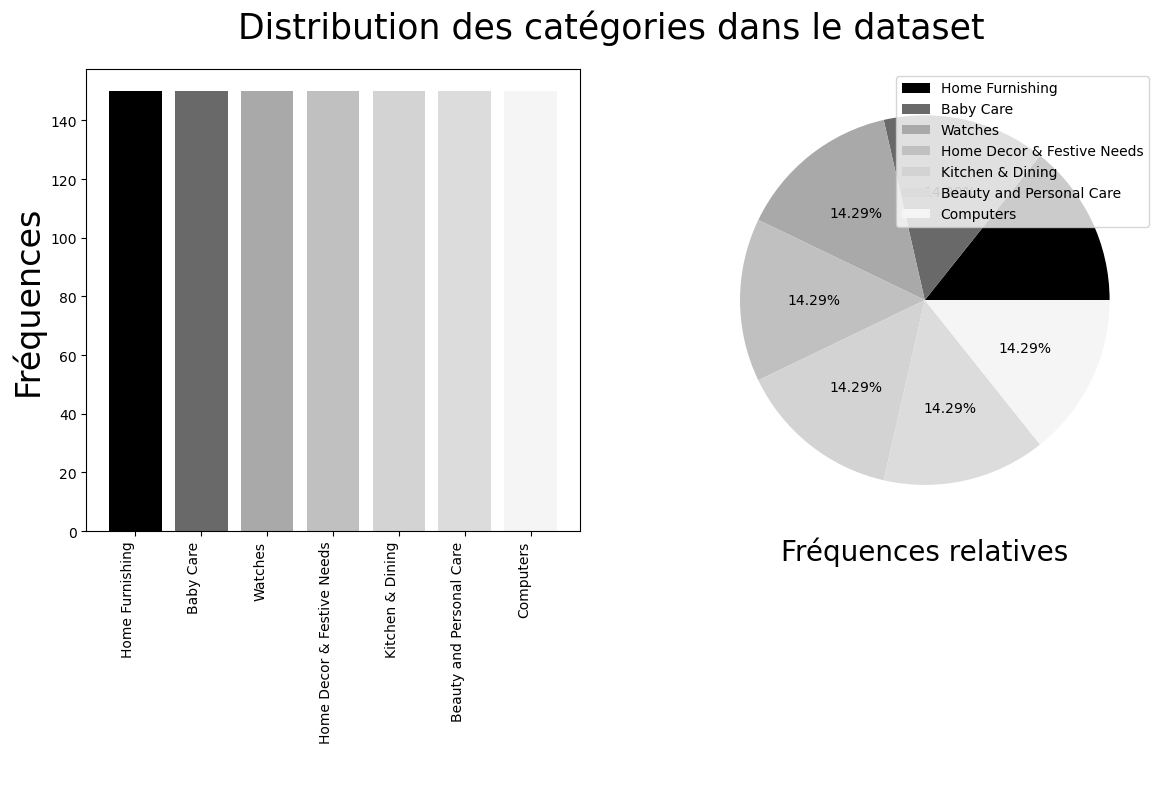

In [152]:
nb_cat1 = data['cat_1'].nunique()
fig = categorical_distribution(data['cat_1'])


In [153]:
# nb_cat2 = data['cat_2'].nunique()
# print('{} categories au deuxieme niveau.'.format(nb_cat2))
# fig = plot_pie(data['cat_2'])


In [154]:
# nb_cat3 = data['cat_3'].nunique()
# print('{} categories au troisieme niveau.'.format(nb_cat3))
# fig = plot_pie(data['cat_3'])


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">b. Exploration du jeu de données entier</h4>
</div>

In [155]:
# imputation des NaN dans 'brand' -> ''
data['brand'] = data['brand'].fillna('')


In [156]:
#  product name, description et brand en une nouvelle feature
data['descriptions'] = data['product_name'] + \
    ' ' + data['description'] + ' ' + data['brand']
corpus = data['descriptions'].str.cat(sep=' ')

In [157]:
# Générer la liste de mots
list_words = corpus.split()
print("Nombre de mots au total: {}".format(len(list_words)))
print("Nombre de mots uniques: {}".format(len(set(list_words))))


Nombre de mots au total: 88668
Nombre de mots uniques: 9593


In [158]:
#data.to_csv('data_test.csv', index=False)


In [159]:
data['cat_1'].value_counts()


Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: cat_1, dtype: int64

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1. Prétraiter des données textes pour obtenir un jeu de données exploitable. </h3>
</div>

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Nettoyer les champs de texte (ponctuation/mots de liaison/mise en minuscules).</h4>
</div>

In [160]:
# Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize


def tokenizer_fct(sentence):
    # print(sentence)
    sentence_clean = sentence.replace(
        '-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens


# Stop words
stop_w = list(set(stopwords.words('english'))) + \
    ['[', ']', ',', '.', ':', '?', '(', ')']


def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha


def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
          #                                   and (not w.startswith("#"))
          and (not w.startswith("http"))]
    return lw


# Lemmatizer (base d'un mot)


def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)


def transform_bow_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization


def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)


def transform_dl_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    # sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


data['sentence_bow'] = data['descriptions'].apply(
    lambda x: transform_bow_fct(x))
data['sentence_bow_lem'] = data['descriptions'].apply(
    lambda x: transform_bow_lem_fct(x))
data['sentence_dl'] = data['descriptions'].apply(lambda x: transform_dl_fct(x))
data.shape

(1050, 13)

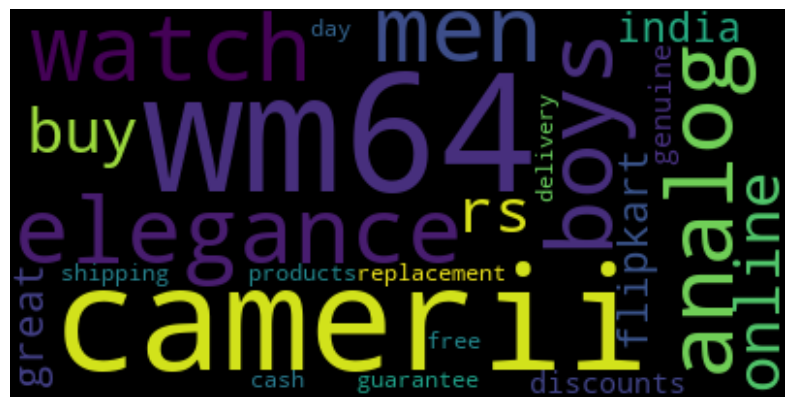

In [161]:
# Start with one review:
text = data.sentence_bow[6]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
fig = plt.figure(figsize=(10, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [162]:
# phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes.
text

'camerii wm64 elegance analog watch for men boys camerii wm64 elegance analog watch for men boys buy camerii wm64 elegance analog watch for men boys wm64 online rs.449 india only flipkart.com great discounts only genuine products day replacement guarantee free shipping cash delivery'

In [163]:
l_cat = list(set(data['cat_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data.iloc[i]['cat_1'])) for i in range(len(data))]


catégories :  ['Beauty and Personal Care', 'Kitchen & Dining', 'Home Decor & Festive Needs', 'Home Furnishing', 'Baby Care', 'Watches', 'Computers']


In [164]:
from nltk.tokenize import sent_tokenize, word_tokenize

data['length_bow'] = data['sentence_bow'].apply(
    lambda x: len(word_tokenize(x)))
print("max length bow : ", data['length_bow'].max())
data['length_bow_lem'] = data['sentence_bow_lem'].apply(
    lambda x: len(word_tokenize(x)))
print("max length bow lem: ", data['length_bow_lem'].max())
data['length_dl'] = data['sentence_dl'].apply(lambda x: len(word_tokenize(x)))
print("max length dl : ", data['length_dl'].max())

max length bow :  385
max length bow lem:  385
max length dl :  638


In [165]:
import time

from sklearn import cluster, manifold, metrics

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def ARI_fct(features):
    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions-produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions-produits par clusters')

    plt.show()
    print("ARI : ", ARI)

In [166]:
data


uniq_id                                       product_name                              product_category_tree                                 image                                        description                  brand            cat_1                   cat_2             cat_3                                       descriptions                                       sentence_bow                                   sentence_bow_lem                                        sentence_dl  length_bow  length_bow_lem  length_dl
0     55b85ea15a1536d46b7190ad6fff8ce7  Elegance Polyester Multicolor Abstract Eyelet ...  ["Home Furnishing >> Curtains & Accessories >>...  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Key Features of Elegance Polyester Multicolor ...               Elegance  Home Furnishing  Curtains & Accessories          Curtains  Elegance Polyester Multicolor Abstract Eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...         164             164        256
1     7b72c92c2f6c40268628ec5f14c6d590                         Sathiyas Cotton Bath Towel  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  7b72c92c2f6c40268628ec5f14c6d590.jpg  Specifications of Sathiyas Cotton Bath Towel (...               Sathiyas        Baby Care        Baby Bath & Skin  Baby Bath Towels  Sathiyas Cotton Bath Towel Specifications of S...  sathiyas cotton bath towel specifications sath...  sathiyas cotton bath towel specification sathi...  sathiyas cotton bath towel specifications of s...          68              68         89
2     64d5d4a258243731dc7bbb1eef49ad74                Eurospa Cotton Terry Face Towel Set  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  64d5d4a258243731dc7bbb1eef49ad74.jpg  Key Features of Eurospa Cotton Terry Face Towe...                Eurospa        Baby Care        Baby Bath & Skin  Baby Bath Towels  Eurospa Cotton Terry Face Towel Set Key Featur...  eurospa cotton terry face towel set key featur...  eurospa cotton terry face towel set key featur...  eurospa cotton terry face towel set key featur...         165             165        259
3     d4684dcdc759dd9cdf41504698d737d8  SANTOSH ROYAL FASHION Cotton Printed King size...  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  d4684dcdc759dd9cdf41504698d737d8.jpg  Key Features of SANTOSH ROYAL FASHION Cotton P...  SANTOSH ROYAL FASHION  Home Furnishing               Bed Linen         Bedsheets  SANTOSH ROYAL FASHION Cotton Printed King size...  santosh royal fashion cotton printed king size...  santosh royal fashion cotton printed king size...  santosh royal fashion cotton printed king size...         126             126        160
4     6325b6870c54cd47be6ebfbffa620ec7  Jaipur Print Cotton Floral King sized Double B...  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  6325b6870c54cd47be6ebfbffa620ec7.jpg  Key Features of Jaipur Print Cotton Floral Kin...           Jaipur Print  Home Furnishing               Bed Linen         Bedsheets  Jaipur Print Cotton Floral King sized Double B...  jaipur print cotton floral king sized double b...  jaipur print cotton floral king sized double b...  jaipur print cotton floral king sized double b...         166             166        238
...                                ...                                                ...                                                ...                                   ...                                                ...                    ...              ...                     ...               ...                                                ...                                                ...                                                ...                                                ...         ...             ...        ...
1045  958f54f4c46b53c8a0a9b8167d9140bc     Oren Empower Extra Large Self Adhesive Sticker  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  958f

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">b. Features engeneering = encodage tf-idf + nettoyages supplementaires.</h4>
</div>

In [167]:
# Convertir une collection de documents bruts en une matrice de caractéristiques TF-IDF.
# Équivalent à CountVectorizer suivi de TfidfTransformer.


In [168]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data[feat])
ctf_fit = ctf.fit(data[feat])

cv_transform = cvect.transform(data[feat])
ctf_transform = ctf.transform(data[feat])

In [169]:
cv_transform.shape


(1050, 5324)

In [170]:
ctf_transform.shape


(1050, 5324)

In [171]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------


c:\Users\camil\anaconda3\envs\camille\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4683 time :  9.0

Tf-idf : 
--------


c:\Users\camil\anaconda3\envs\camille\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.5494 time :  8.0


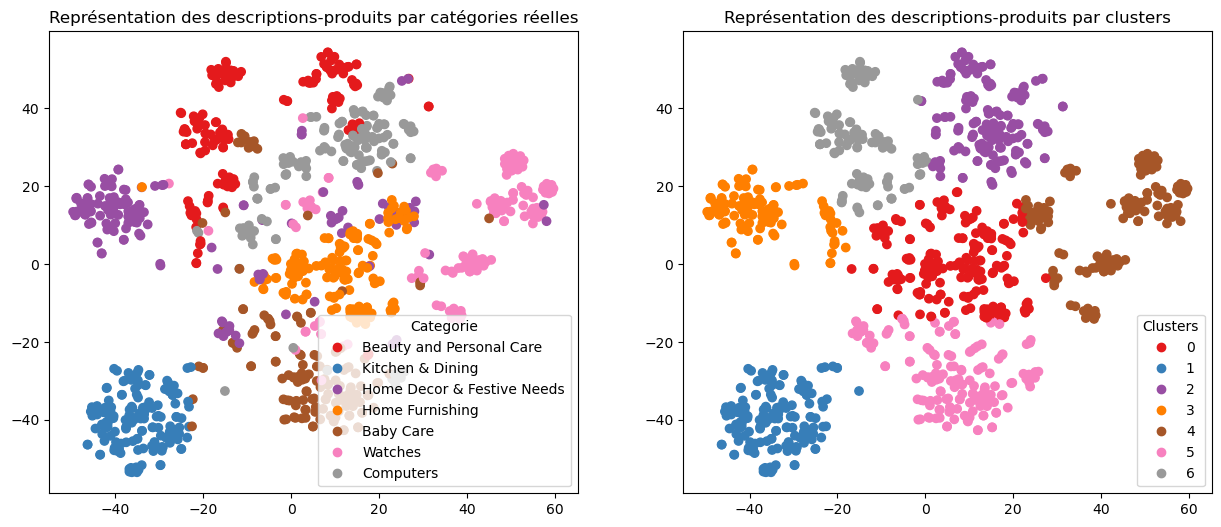

ARI :  0.5494


In [172]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">c. Méthodes de word/sentence embedding (Word2Vec (ou Doc2Vec ou Glove ou FastText), BERT, et USE (Universal Sentence Encoder))</h4>
</div>

In [173]:
# Le word embedding/L'incorporation de mots est le processus de conversion d'un texte en données numériques. (vecteur dense)
# Étant donné que les ordinateurs ne fonctionnent qu'avec des nombres et ne peuvent pas calculer avec
# précision les données sous forme de chaînes de caractères, les mots sont intégrés dans un nombre entier
# unique ou un code numérique. Par exemple, le mot "sévère" est fixé sous la forme d'un nombre "3214".

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">- word2vec</h4>
</div>

In [174]:
# word2vec utilise un réseau neuronal pour prédire les mots cibles dans les phrases et prend le coefficient de la dernière couche du réseau neuronal comme éléments du vecteur de mots.
# GloVe se concentre sur la capture de la similarité du contexte entre les mots. Il est plus léger et plus efficace que word2vec.
# fastText fonctionne avec la tokenisation des n-grammes et, par conséquent, peut traiter les mots hors vocabulaire.

In [175]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import gensim

In [176]:
w2v_size = 100
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 385 # adapt to length of sentences
sentences = data['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [177]:
# max length bow :  385
# max length dl :  638

In [178]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...


Vocabulary size: 4712
Word2Vec trained


In [179]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


In [180]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 100)


In [181]:
# Création du modèle

input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 385)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 385, 100)          471300    
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 471,300
Trainable params: 471,300
Non-trainable params: 0
_________________________________________________________________


In [182]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape


33/33 [==============================] - 0s 508us/step


(1050, 100)

In [183]:
ARI, X_tsne, labels = ARI_fct(embeddings)


c:\Users\camil\anaconda3\envs\camille\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.3722 time :  9.0


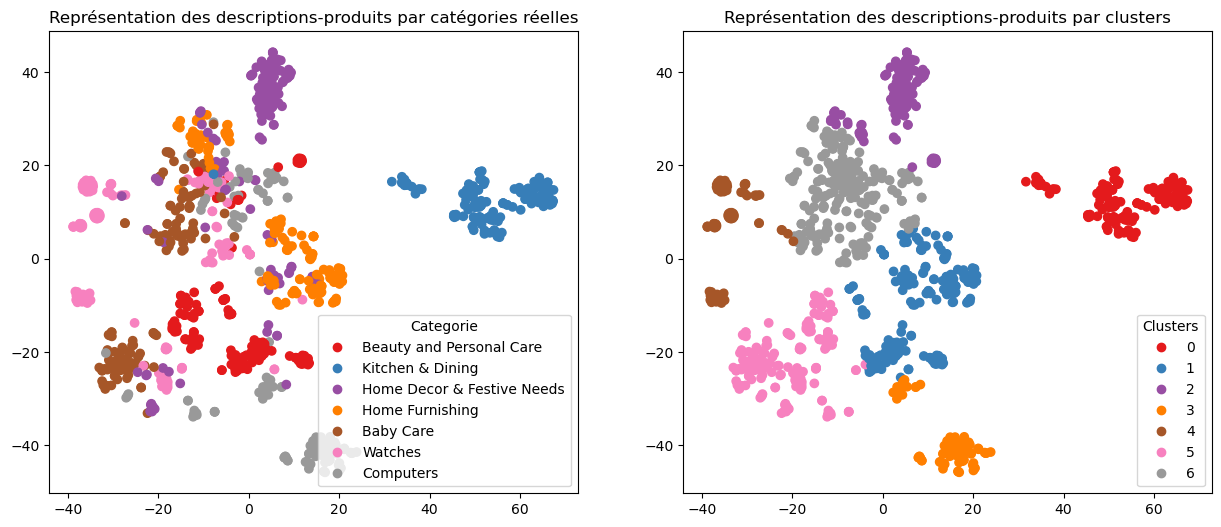

ARI :  0.3722


In [184]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">- BERT</h4>
</div>

In [185]:
#BERT et USE NE FONCTIONNENT QU'AVEC COLAB (PROBLEME TELECHARGEMENT TENSORFLOW) D'OU LA MISE EN COMMENTAIRE ICI SUR VSCODE

In [186]:
# import tensorflow as tf
# # import tensorflow_hub as hub
# import tensorflow.keras
# from tensorflow.keras import backend as K

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras import metrics as kmetrics
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model

# # Bert
# import os
# import transformers

# os.environ["TF_KERAS"]='1'

In [187]:
# print(tf.__version__)
# print(tensorflow.__version__)
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print(tf.test.is_built_with_cuda())


In [188]:
# # Fonction de préparation des sentences
# def bert_inp_fct(sentences, bert_tokenizer, max_length) :
#     input_ids=[]
#     token_type_ids = []
#     attention_mask=[]
#     bert_inp_tot = []

#     for sent in sentences:
#         bert_inp = bert_tokenizer.encode_plus(sent,
#                                               add_special_tokens = True,
#                                               max_length = max_length,
#                                               padding='max_length',
#                                               return_attention_mask = True,
#                                               return_token_type_ids=True,
#                                               truncation=True,
#                                               return_tensors="tf")

#         input_ids.append(bert_inp['input_ids'][0])
#         token_type_ids.append(bert_inp['token_type_ids'][0])
#         attention_mask.append(bert_inp['attention_mask'][0])
#         bert_inp_tot.append((bert_inp['input_ids'][0],
#                              bert_inp['token_type_ids'][0],
#                              bert_inp['attention_mask'][0]))

#     input_ids = np.asarray(input_ids)
#     token_type_ids = np.asarray(token_type_ids)
#     attention_mask = np.array(attention_mask)

#     return input_ids, token_type_ids, attention_mask, bert_inp_tot


# # Fonction de création des features
# def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
#     batch_size = b_size
#     batch_size_pred = b_size
#     bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
#     time1 = time.time()

#     for step in range(len(sentences)//batch_size) :
#         idx = step*batch_size
#         input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
#                                                                       bert_tokenizer, max_length)

#         if mode=='HF' :    # Bert HuggingFace
#             outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
#             last_hidden_states = outputs.last_hidden_state

#         if mode=='TFhub' : # Bert Tensorflow Hub
#             text_preprocessed = {"input_word_ids" : input_ids,
#                                  "input_mask" : attention_mask,
#                                  "input_type_ids" : token_type_ids}
#             outputs = model(text_preprocessed)
#             last_hidden_states = outputs['sequence_output']

#         if step ==0 :
#             last_hidden_states_tot = last_hidden_states
#             last_hidden_states_tot_0 = last_hidden_states
#         else :
#             last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

#     features_bert = np.array(last_hidden_states_tot).mean(axis=1)

#     time2 = np.round(time.time() - time1,0)
#     print("temps traitement : ", time2)

#     return features_bert, last_hidden_states_tot

In [189]:
# from transformers import TFAutoModel

# max_length = 638
# batch_size = 10
# model_type = 'bert-base-uncased'
# model = TFAutoModel.from_pretrained(model_type)
# sentences = data['sentence_dl'].to_list()


In [190]:
# # Création des features

# features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
#                                                          max_length, batch_size, mode='HF')

In [191]:
# ARI, X_tsne, labels = ARI_fct(features_bert)


In [192]:
# TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


In [193]:
# BERT_Hub

In [194]:
# import os
# import shutil

# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text
# #from official.nlp import optimization  # to create AdamW optimizer

# import matplotlib.pyplot as plt

# tf.get_logger().setLevel('ERROR')


In [195]:
# import tensorflow_hub as hub
# import tensorflow_text

# # Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
# bert_layer = hub.KerasLayer(model_url, trainable=True)

In [196]:
# sentences = data['sentence_dl'].to_list()


In [197]:
# max_length = 638
# batch_size = 10
# model_type = 'bert-base-uncased'
# model = bert_layer

# features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
#                                                          max_length, batch_size, mode='TFhub')

In [198]:
# ARI, X_tsne, labels = ARI_fct(features_bert)


In [199]:
# TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">- USE</h4>
</div>

In [200]:
# #@title Load the Universal Sentence Encoder's TF Hub module
# from absl import logging

# import tensorflow as tf

# import tensorflow_hub as hub
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import pandas as pd
# import re
# import seaborn as sns

# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
# embed = hub.load(module_url)
# print ("module %s loaded" % module_url)


In [201]:
# def feature_USE_fct(sentences, b_size) :
#     batch_size = b_size
#     time1 = time.time()

#     for step in range(len(sentences)//batch_size) :
#         idx = step*batch_size
#         feat = embed(sentences[idx:idx+batch_size])

#         if step ==0 :
#             features = feat
#         else :
#             features = np.concatenate((features,feat))

#     time2 = np.round(time.time() - time1,0)
#     return features


In [202]:
# batch_size = 10
# sentences = data['sentence_dl'].to_list()


In [203]:
# features_USE = feature_USE_fct(sentences, batch_size)


In [204]:
# ARI, X_tsne, labels = ARI_fct(features_USE)


In [205]:
# TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Prétraitement des données images pour obtenir un jeu de données exploitable. </h3>
</div>

In [206]:
data


uniq_id                                       product_name                              product_category_tree                                 image                                        description                  brand            cat_1                   cat_2             cat_3                                       descriptions                                       sentence_bow                                   sentence_bow_lem                                        sentence_dl  length_bow  length_bow_lem  length_dl
0     55b85ea15a1536d46b7190ad6fff8ce7  Elegance Polyester Multicolor Abstract Eyelet ...  ["Home Furnishing >> Curtains & Accessories >>...  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Key Features of Elegance Polyester Multicolor ...               Elegance  Home Furnishing  Curtains & Accessories          Curtains  Elegance Polyester Multicolor Abstract Eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...         164             164        256
1     7b72c92c2f6c40268628ec5f14c6d590                         Sathiyas Cotton Bath Towel  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  7b72c92c2f6c40268628ec5f14c6d590.jpg  Specifications of Sathiyas Cotton Bath Towel (...               Sathiyas        Baby Care        Baby Bath & Skin  Baby Bath Towels  Sathiyas Cotton Bath Towel Specifications of S...  sathiyas cotton bath towel specifications sath...  sathiyas cotton bath towel specification sathi...  sathiyas cotton bath towel specifications of s...          68              68         89
2     64d5d4a258243731dc7bbb1eef49ad74                Eurospa Cotton Terry Face Towel Set  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  64d5d4a258243731dc7bbb1eef49ad74.jpg  Key Features of Eurospa Cotton Terry Face Towe...                Eurospa        Baby Care        Baby Bath & Skin  Baby Bath Towels  Eurospa Cotton Terry Face Towel Set Key Featur...  eurospa cotton terry face towel set key featur...  eurospa cotton terry face towel set key featur...  eurospa cotton terry face towel set key featur...         165             165        259
3     d4684dcdc759dd9cdf41504698d737d8  SANTOSH ROYAL FASHION Cotton Printed King size...  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  d4684dcdc759dd9cdf41504698d737d8.jpg  Key Features of SANTOSH ROYAL FASHION Cotton P...  SANTOSH ROYAL FASHION  Home Furnishing               Bed Linen         Bedsheets  SANTOSH ROYAL FASHION Cotton Printed King size...  santosh royal fashion cotton printed king size...  santosh royal fashion cotton printed king size...  santosh royal fashion cotton printed king size...         126             126        160
4     6325b6870c54cd47be6ebfbffa620ec7  Jaipur Print Cotton Floral King sized Double B...  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  6325b6870c54cd47be6ebfbffa620ec7.jpg  Key Features of Jaipur Print Cotton Floral Kin...           Jaipur Print  Home Furnishing               Bed Linen         Bedsheets  Jaipur Print Cotton Floral King sized Double B...  jaipur print cotton floral king sized double b...  jaipur print cotton floral king sized double b...  jaipur print cotton floral king sized double b...         166             166        238
...                                ...                                                ...                                                ...                                   ...                                                ...                    ...              ...                     ...               ...                                                ...                                                ...                                                ...                                                ...         ...             ...        ...
1045  958f54f4c46b53c8a0a9b8167d9140bc     Oren Empower Extra Large Self Adhesive Sticker  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  958f

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Prétraitement d'images (contraste etc) OpenCV </h4>
</div>

In [207]:
# data.loc[data['image']=="33d97d63c037078cd3f08033966d6a88.jpg"]

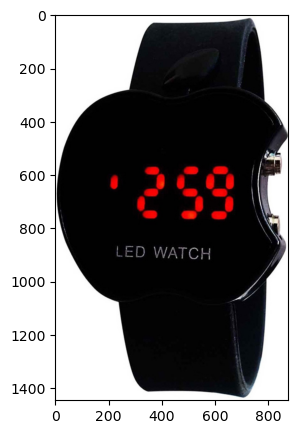

In [208]:
import cv2
import os
from matplotlib import pyplot as plt

#  Get an exemple of image path
image_name = data['image'].loc[19]
dir_name = 'Flipkart\Images'
file_path = os.path.join(dir_name, image_name)

# Read the file and convert it to color image
img = cv2.imread(file_path)
RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display image
plt.imshow(RGB_im)

In [209]:
def resize_image(img, size, interpolation):
    """Function to resize image without deformation."""

    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]

    if h == w:
        return cv2.resize(img, (size, size), interpolation)
    if h > w:
        dif = h
    else:
        dif = w

    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)

    if c is None:
        #  mask = np.zeros((dif, dif), dtype=img.dtype)
        mask = np.full((dif, dif), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]

    else:
        #  mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask = np.full((dif, dif, c), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, (size, size), interpolation)

(224, 224, 3)


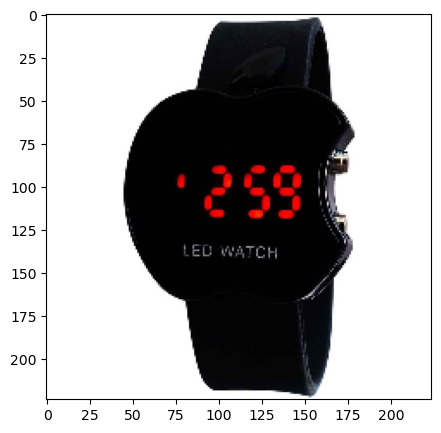

In [210]:
squared_image = resize_image(RGB_im, size=224, interpolation=cv2.INTER_AREA)
print(squared_image.shape)
plt.imshow(squared_image)

In [211]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping


def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index - 1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size - 1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

C:\Users\camil\AppData\Local\Temp\ipykernel_21236\818085478.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accumulator.append(float(hist[0]))
C:\Users\camil\AppData\Local\Temp\ipykernel_21236\818085478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accumulator.append(accumulator[index - 1] + float(hist[index]))


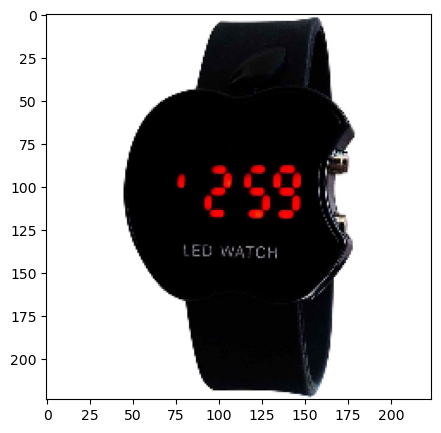

In [212]:
auto_result, alpha, beta = automatic_brightness_and_contrast(squared_image)
plt.imshow(auto_result)


In [213]:
import os
import cv2  # opencv library for computer vision

# initializations
dir_read = 'Flipkart\Images'
dir_write = 'Flipkart\preprocessed_images'

#  for each product in the data
for index, row in data.iterrows():

    # get url of the product's image
    img_name = row['image']

    #  create the path to the image file
    img_path = os.path.join(dir_read, img_name)

    # Read the file and convert it to color image
    img_file = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)

    # resize the image to 224*224 pixels
    img_sqr = resize_image(img_rgb, size=224, interpolation=cv2.INTER_AREA)

    #  auto-adjustment of contrast and luminosity
    img_preprocessed, alpha, beta = automatic_brightness_and_contrast(img_sqr)

    # save the preprocessed image
    img_preprocessed_path = os.path.join(dir_write, img_name)
    cv2.imwrite(img_preprocessed_path, img_preprocessed)

C:\Users\camil\AppData\Local\Temp\ipykernel_21236\818085478.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accumulator.append(float(hist[0]))
C:\Users\camil\AppData\Local\Temp\ipykernel_21236\818085478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accumulator.append(accumulator[index - 1] + float(hist[index]))


In [214]:
from IPython.core.display import HTML

dir_name = '.\Flipkart\preprocessed_images'
tags = []

#  Getting the list of categories of product
categories_list = list(data['cat_1'].unique())

# Iterating over categories of products
for category in categories_list:

    # Sampling n products belonging to the category
    mask = data['cat_1'] == category
    sample = data[mask].sample(n=15)

    # Iterating over each product in the sample

    tags.append('<br><b>{}</b><br>'.format(category))
    for index, row in sample.iterrows():
        # getting the path of image
        img_name = row['image']
        img_path = os.path.join(dir_name, img_name)

        # Create the html code for displaying the images
        tags.append(
            '<img src="{}" width="50" style="display:inline"/>'.format(img_path))

tags.append('<br>')
# Display the images of the category
HTML(''.join(tags))

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">b. Pré-traitement des images via SIFT</h4>
</div>

In [215]:
# from os import listdir
path = 'Flipkart\preprocessed_images'
#path = r"C:\Users\camil\Desktop\Python_env\Projet6\Flipkart\preprocessed_images"
#path + "\\" + data['image'][index]
# list_photos = [file for file in listdir(path)]


In [216]:
# identification of key points and associated descriptors
import time
time1 = time.time()

sift_keypoints = []
sift = cv2.SIFT_create(nfeatures=50000) # nfeatures < 224*224 <=> 50176

for index in range(len(data)):
    if index % 10 == 0:
        print(index, "", end='')
    # ouverture fichier image et conversion en niveaux de gris
    image = cv2.imread(path + "\\" + data['image'][index], 0)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

time2 = np.round(time.time() - time1, 0)
print("time : ", time2)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 time :  6.0


In [217]:
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Dimension des descripteurs : ", sift_keypoints_all.shape)



Dimension des descripteurs :  (237954, 128)


In [218]:
from sklearn.cluster import MiniBatchKMeans


k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters : ", k)

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k,
                         random_state=42, n_init=100, batch_size=2050)
kmeans.fit(sift_keypoints_all)

Nombre de clusters :  488


MiniBatchKMeans(batch_size=2050, init_size=1464, n_clusters=488, n_init=100,
                random_state=42)

In [219]:
# Creation of histograms (features)
temps1 = time.time()


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            41.74 secondes


In [220]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 488)
Dimensions dataset après réduction PCA :  (1050, 411)


In [221]:
# Une projection sur le premier plan factoriel ne semble pas pertinente, car ses 2 axes ne représentent que 6% de l'inertie.


In [222]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["cat_1"]
print(df_tsne.shape)

(1050, 3)


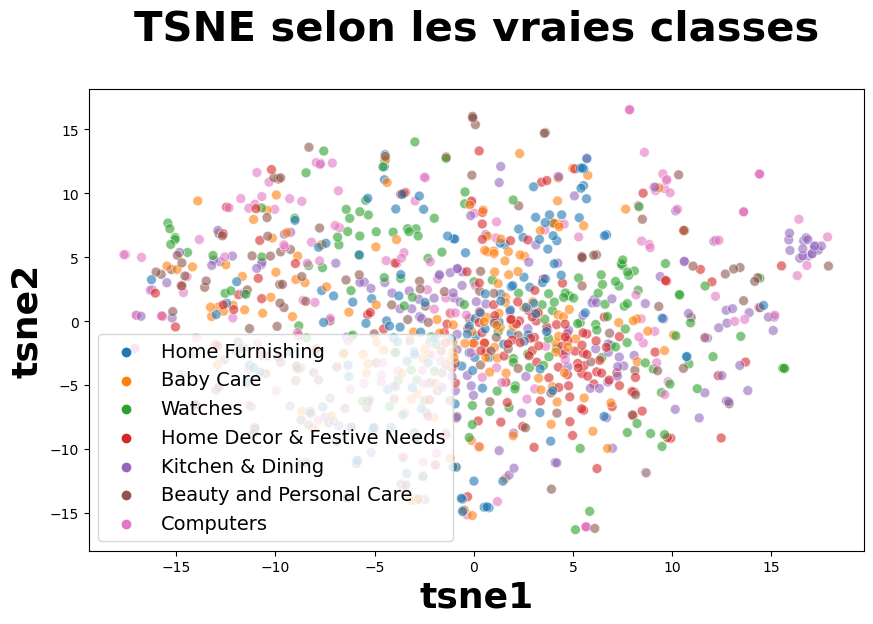

In [223]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

In [224]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=42, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


c:\Users\camil\anaconda3\envs\camille\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


In [225]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data["cat_1"])
data["label"] = le.transform(data["cat_1"])


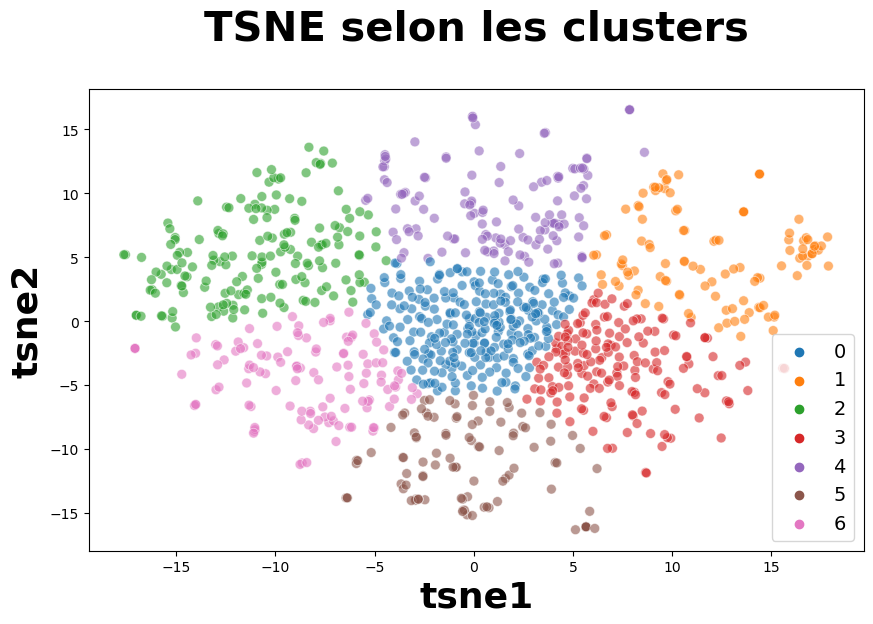

ARI :  0.032626323655674624


In [226]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [227]:
df_tsne.groupby("cluster").count()["class"]


cluster
0    249
1    109
2    169
3    168
4    131
5    102
6    122
Name: class, dtype: int64

In [228]:
df_tsne


tsne1   tsne2            class  cluster
0     -2.3832 -7.1872  Home Furnishing        5
1    -11.0983  7.9562        Baby Care        2
2     -8.0752 -8.4094        Baby Care        6
3      4.4323  8.3147  Home Furnishing        4
4      2.4832  6.5528  Home Furnishing        4
...       ...     ...              ...      ...
1045  -0.2010  9.0982        Baby Care        4
1046 -11.5492  0.8800        Baby Care        2
1047   1.1630 -0.3310        Baby Care        0
1048 -13.2707  1.0896        Baby Care        2
1049   4.5706 -4.0489        Baby Care        3

[1050 rows x 4 columns]

In [229]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)


[[42  2 27 22 27 15 15]
 [25 15 32 10 12 14 42]
 [19 30 36 11 17 16 21]
 [46  7 15 51 14 12  5]
 [50  3 11  7 35 26 18]
 [34 33 20 32 10 11 10]
 [33 19 28 35 16  8 11]]


In [230]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    #corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 1, 2, 0, 4, 5, 6]
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']


cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3, 1, 2, 0, 4, 5, 6]
[[22  2 27 42 27 15 15]
 [10 15 32 25 12 14 42]
 [11 30 36 19 17 16 21]
 [51  7 15 46 14 12  5]
 [ 7  3 11 50 35 26 18]
 [32 33 20 34 10 11 10]
 [35 19 28 33 16  8 11]]

              precision    recall  f1-score   support

           0       0.13      0.15      0.14       150
           1       0.14      0.10      0.12       150
           2       0.21      0.24      0.23       150
           3       0.18      0.31      0.23       150
           4       0.27      0.23      0.25       150
           5       0.11      0.07      0.09       150
           6       0.09      0.07      0.08       150

    accuracy                           0.17      1050
   macro avg       0.16      0.17      0.16      1050
weighted avg       0.16      0.17      0.16      1050



In [231]:
list_labels = data['cat_1'].unique().tolist()
list_labels


['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

<Axes: >

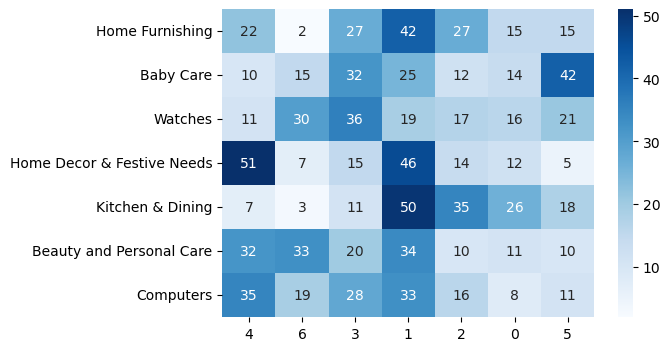

In [232]:
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in "4631205"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">c. Extraction des features par CNN</h4>
</div>

In [233]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from glob import glob
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from os import listdir
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [234]:
import os
import random
import shutil

data_path = "Flipkart/preprocessed_images_copie"

# path to destination folders
train_folder = os.path.join(data_path, 'train')
val_folder = os.path.join(data_path, 'eval')
test_folder = os.path.join(data_path, 'test')

# Define a list of image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Create a list of image filenames in 'data_path'
imgs_list = [filename for filename in os.listdir(
    data_path) if os.path.splitext(filename)[-1] in image_extensions]

# Sets the random seed
random.seed(42)

# Shuffle the list of image filenames
random.shuffle(imgs_list)

# determine the number of images for each set
train_size = int(len(imgs_list) * 0.7)
val_size = int(len(imgs_list) * 0.15)
test_size = int(len(imgs_list) * 0.15)

# Create destination folders if they don't exist
for folder_path in [train_folder, val_folder, test_folder]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Copy image files to destination folders
for i, f in enumerate(imgs_list):
    if i < train_size:
        dest_folder = train_folder
    elif i < train_size + val_size:
        dest_folder = val_folder
    else:
        dest_folder = test_folder
    shutil.copy(os.path.join(data_path, f), os.path.join(dest_folder, f))

In [235]:
imgs_list


['353ddb2c8ab6920d8ad1055abee87dda.jpg',
 'd7fded8e211b3033e424fb450b97caec.jpg',
 '00ed03657cedbe4663eff2d7fa702a33.jpg',
 'edec3bb5df9c4bc618752e94532bb36e.jpg',
 '55ce1309b69e1912d2fd60a3ee3f351b.jpg',
 'b46d7b8e6826ad4c8b40a991da0f54d7.jpg',
 'e1b2b3ad430dd738d958292441b6d046.jpg',
 '387ecd9ec173d61b6dc5ceddc079b150.jpg',
 'a76bf8400b3dbcdbe5a5678f4a8ea0f6.jpg',
 '28e3f1e490cfc4b47bfb50671ff93283.jpg',
 'b7214d4c357e3f7acae72fcbe7d31afe.jpg',
 '46c7cb82a768ad8811db821d8649f6e0.jpg',
 'b5aafdb7cfde56f3e9e1364eb1efb691.jpg',
 '873a955df5a2f677a41a7efc94060e41.jpg',
 '321f2ab0dd243778c87ac63ace6639f4.jpg',
 'c5590e238d44b370337624f5987fb9b8.jpg',
 'de29bf3288345e23b0e25345a3a057fb.jpg',
 'b4327c9879644be2a04e9b2df963f6cb.jpg',
 '2eb07dc77e2fc7e3668fd7ed9b864039.jpg',
 '7fd12776e6d62da6e1dd3cbc9882ee5f.jpg',
 '44a6d9f64668b004c3254f3904142064.jpg',
 '724e6eb7edc83eb48b6492d12e940ebd.jpg',
 'cf6a4daf0e795838061b0eb832bbc99d.jpg',
 'aab46b84f70cc6774afaafe1d6035de3.jpg',
 'a554abb9699959

In [236]:
df = data[['image', 'cat_1', 'label', 'descriptions']]
df['image_path'] = "Flipkart/preprocessed_images_copie/" + df['image']
df = df.rename(columns={'cat_1': 'label_name'})
df.shape

C:\Users\camil\AppData\Local\Temp\ipykernel_21236\1037602275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_path'] = "Flipkart/preprocessed_images_copie/" + df['image']


(1050, 5)

In [237]:
df.to_csv("df.csv", index=False)


In [238]:
list_labels = df["label_name"].unique().tolist()
list_labels


['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

Home Furnishing


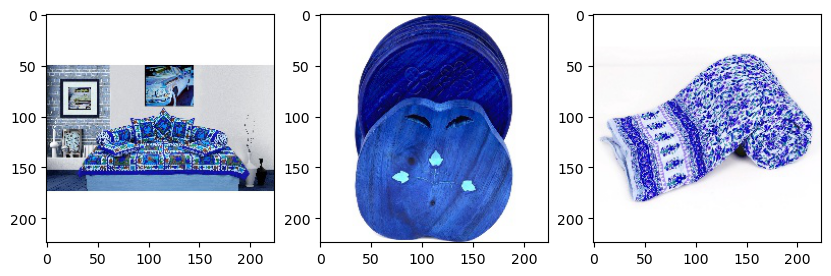

Baby Care


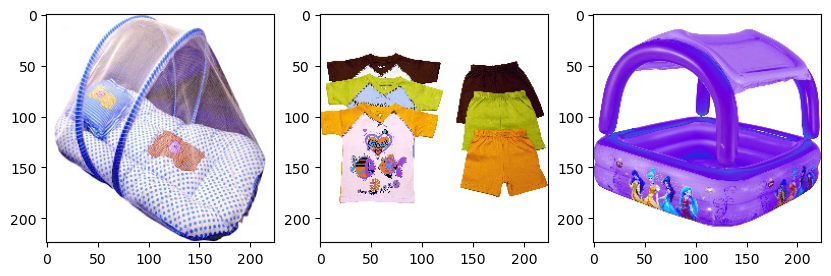

Watches


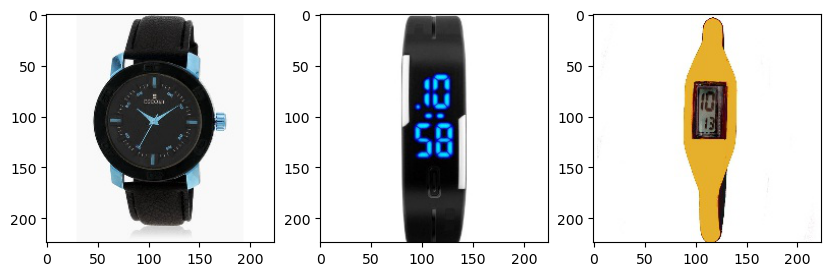

Home Decor & Festive Needs


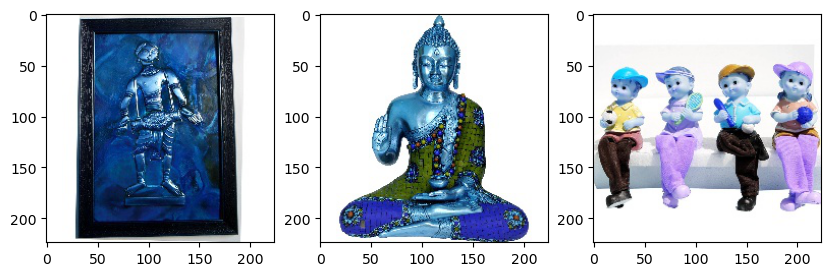

Kitchen & Dining


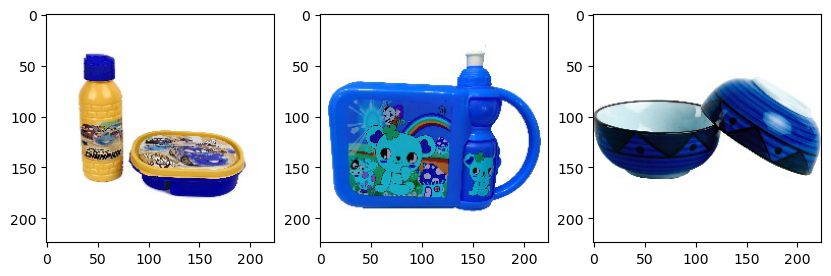

Beauty and Personal Care


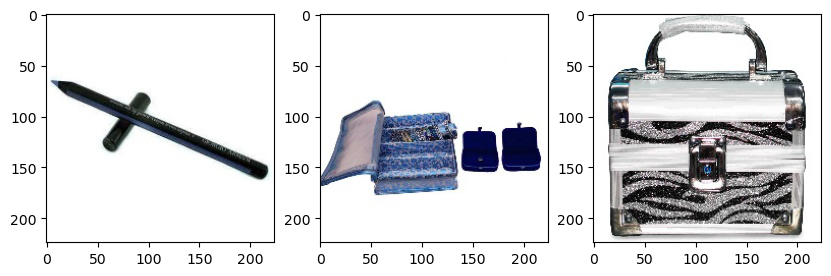

Computers


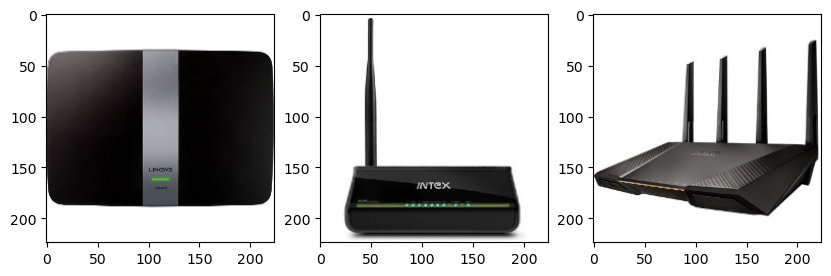

In [239]:
from matplotlib.image import imread


def list_fct(name):
    list_image_name = [df["image_path"][i]
                       for i in range(len(df)) if df["label_name"][i] == name]
    return list_image_name


list_home = [df["image_path"][i]
             for i in range(len(df)) if df["label_name"][i] == "Home Furnishing"]
list_baby = [df["image_path"][i]
             for i in range(len(df)) if df["label_name"][i] == "Baby Care"]
list_watches = [df["image_path"][i]
                for i in range(len(df)) if df["label_name"][i] == "Watches"]
list_decor = [df["image_path"][i] for i in range(
    len(df)) if df["label_name"][i] == "Home Decor & Festive Needs"]
list_kitchen = [df["image_path"][i] for i in range(
    len(df)) if df["label_name"][i] == "Kitchen & Dining"]
list_beauty = [df["image_path"][i] for i in range(
    len(df)) if df["label_name"][i] == "Beauty and Personal Care"]
list_computers = [df["image_path"][i]
                  for i in range(len(df)) if df["label_name"][i] == "Computers"]

for name in list_labels:
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [240]:
data_path_train = "Flipkart/preprocessed_images_copie/train"
data_path_test = "Flipkart/preprocessed_images_copie/test"
data_path_eval = "Flipkart/preprocessed_images_copie/eval"

# Define a list of image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Create a list of image filenames in 'data_path'
imgs_list_train = [filename for filename in os.listdir(
    data_path_train) if os.path.splitext(filename)[-1] in image_extensions]
imgs_list_test = [filename for filename in os.listdir(
    data_path_test) if os.path.splitext(filename)[-1] in image_extensions]
imgs_list_eval = [filename for filename in os.listdir(
    data_path_eval) if os.path.splitext(filename)[-1] in image_extensions]

In [241]:
data_train = pd.DataFrame()
data_train['image'] = imgs_list_train
data_train = data_train.merge(df, on='image', how='inner')
data_train['image_path'] = data_path_train + "/" + data_train['image']
data_train.shape
data_train.to_csv("data_train.csv", index=False)

In [242]:
data_test = pd.DataFrame()
data_test['image'] = imgs_list_test
data_test = data_test.merge(df, on='image', how='inner')
data_test['image_path'] = data_path_test + "/" + data_test['image']
data_test.shape
data_test.to_csv("data_test.csv", index=False)


In [243]:
data_eval = pd.DataFrame()
data_eval['image'] = imgs_list_eval
data_eval = data_eval.merge(df, on='image', how='inner')
data_eval['image_path'] = data_path_eval + "/" + data_eval['image']
data_eval.shape
data_eval.to_csv("data_eval.csv", index=False)


In [244]:
from keras.applications import VGG16

base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [245]:
import time
time1 = time.time()

images_features = []
i = 0
for image_file in data_train["image_path"]:
    if i % 100 == 0:
        print(i)
    i += 1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[
                           0])  # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

time2 = np.round(time.time() - time1, 0)
print("time : ", time2)

0
100
200
300
400
500
600
700
time :  108.0


In [246]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

(735, 4096)
(735, 581)


In [247]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             2.63 secondes


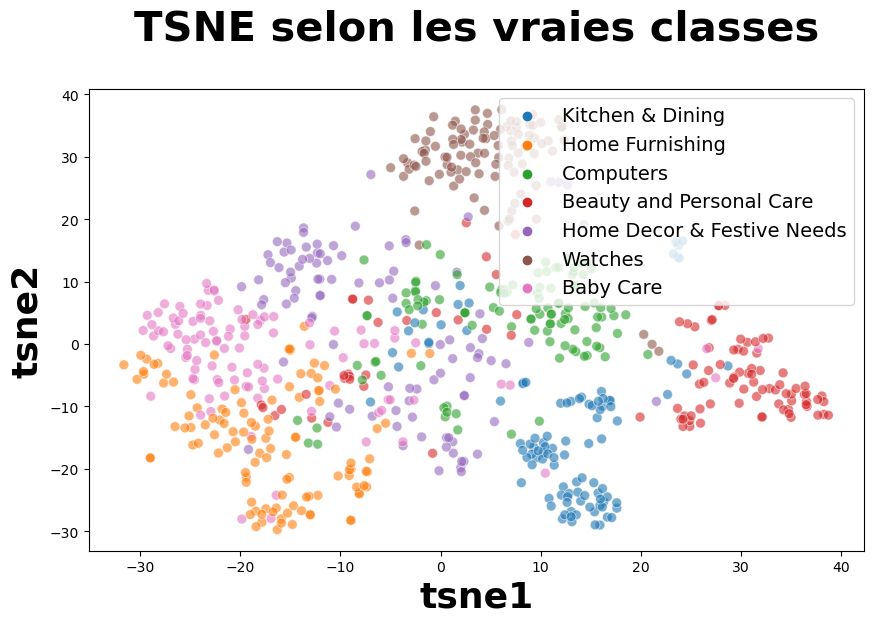

In [248]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_train["label_name"]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, loc="upper right")

plt.show()

In [249]:
#  Extraction des features

In [250]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)


c:\Users\camil\anaconda3\envs\camille\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=7, n_init=100)

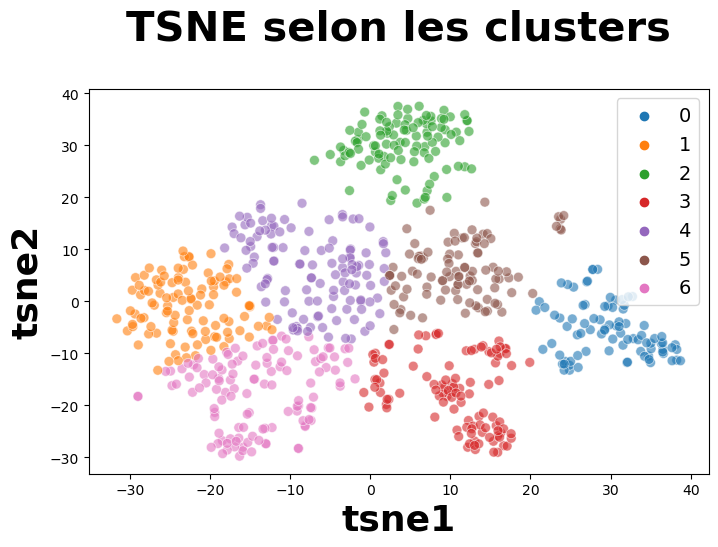

ARI :  0.4887691477232871


In [251]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, loc="upper right")

plt.show()

labels = data_train["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [252]:
# Analyse d'image "home decor" affectées au cluster 3 "watches"

list_decor = [i for i in range(len(data_train["image_path"]))
              if (data_train.iloc[i]['label_name'] == 'Home Decor & Festive Needs') and (df_tsne.iloc[i]['cluster'] == 3)]
list_decor[0]

10

tsne1                          2.7559
tsne2                         20.3666
class      Home Decor & Festive Needs
cluster                             2
Name: 164, dtype: object


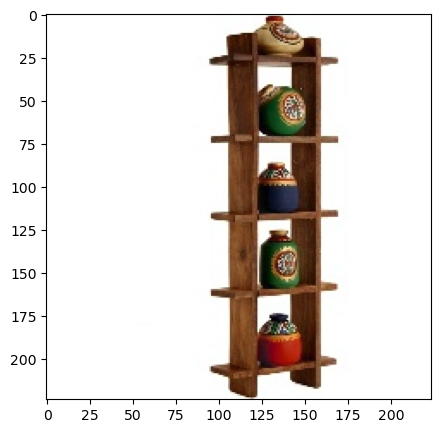

In [253]:
# Analyse d'image "home decor"considéré comme "watches"
from cv2 import imread


id = 164
print(df_tsne.iloc[id])
fig = plt.figure(figsize=(8, 5))
# plt.subplot(130 + 1 + i)
filename = data_train["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()

In [254]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)


[[ 3 74  0  3 10  0 13]
 [74  1  1  2 13  6  8]
 [ 1  0  0  8 25 73  4]
 [ 1  4  5 14 54 10 12]
 [ 0 27  0  0  4  0 81]
 [ 5  0  0 79 11  8  1]
 [ 2  0 96  0  1  1  0]]


In [255]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [256]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))


Correspondance des clusters :  [1 0 6 5 3 2 4]
[[74  3  0 10 13  3  0]
 [ 1 74  6 13  8  2  1]
 [ 0  1 73 25  4  8  0]
 [ 4  1 10 54 12 14  5]
 [27  0  0  4 81  0  0]
 [ 0  5  8 11  1 79  0]
 [ 0  2  1  1  0  0 96]]

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       103
           1       0.86      0.70      0.77       105
           2       0.74      0.66      0.70       111
           3       0.46      0.54      0.50       100
           4       0.68      0.72      0.70       112
           5       0.75      0.76      0.75       104
           6       0.94      0.96      0.95       100

    accuracy                           0.72       735
   macro avg       0.73      0.72      0.73       735
weighted avg       0.73      0.72      0.73       735



<Axes: >

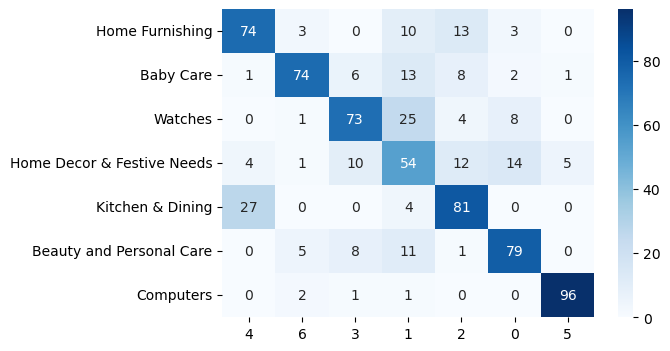

In [257]:
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in "4631205"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [258]:
# La classe la moins bien prédite est "home decor" (CF exemple ci-dessus : confond une étagere avec une montre)
